<a href="https://colab.research.google.com/github/VKSi/2020_12_GB_RecommendationSystems/blob/main/HW_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/RecSys/'

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 10.0MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419431 sha256=51cf852136cd8e27250a8e2f578c54318efc4431f0c27ac7fd065dd68d73d849
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [ ]:
data = pd.read_csv(PATH + 'retail_train.csv')
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [ ]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [ ]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(10)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."
3,7,"[840386, 889774, 898068, 909714, 929067, 95347..."
4,8,"[835098, 872137, 910439, 924610, 992977, 10412..."
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8..."
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884..."
7,14,"[840601, 867293, 933067, 951590, 952408, 96569..."
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13..."
9,16,"[1062973, 1082185, 13007710]"


In [ ]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    #print(flags)
    
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

# Оценивание
За выполнени каждого задания 1 балл

4 балла -> отл

3 балла -> хор

И тд

### Задание 0. Товар 999999
На вебинаре мы использовали товар 999999 - это товар, который НЕ (!!!!!) купили пользователи, если они купиши товар из top5000. Используя этот товар мы смещяем качество рекомендаций. В какую сторону? Уберите этот товар и сравните с качеством на семинаре.

#### Сначала посчитаем результат с фиктивным товаром: 

In [ ]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,25671,6
1,26081,1
2,26093,1
3,26190,1
4,26355,2


In [ ]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [ ]:
# Заведем фиктивный item_id (если юзер НЕ покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,819255,819304,819308,819330,819518,819594,819643,819765,819840,819845,819927,819978,820082,820122,820165,820291,820301,820321,820361,820486,820518,820560,820701,820895,821025,821083,821200,821209,821219,821344,...,13512965,13671759,13672065,13777104,13841744,13842088,13842090,13842214,13842224,13877192,13945141,13945244,13987135,14025185,14043817,14043823,14043825,14043826,14050436,14050460,14050461,14077333,14106445,15452677,15452812,15506577,15511891,15596279,15596488,15596515,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def dict_id_create(user_item_matrix):
  userids = user_item_matrix.index.values
  itemids = user_item_matrix.columns.values

  matrix_userids = np.arange(len(userids))
  matrix_itemids = np.arange(len(itemids))

  id_to_itemid = dict(zip(matrix_itemids, itemids))
  id_to_userid = dict(zip(matrix_userids, userids))

  itemid_to_id = dict(zip(itemids, matrix_itemids))
  userid_to_id = dict(zip(userids, matrix_userids))

  return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

id_to_itemid, id_to_userid, itemid_to_id, userid_to_id = dict_id_create(user_item_matrix)

In [ ]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 2.79 s, sys: 25.6 ms, total: 2.81 s
Wall time: 2.13 s


In [ ]:
%%time

result['itemitem'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 61.6 ms, sys: 999 µs, total: 62.6 ms
Wall time: 63.9 ms


In [ ]:
result.head(2)

,user_id,actual,itemitem
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[999999, 1082185, 981760, 1127831, 995242]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[999999, 1082185, 981760, 1098066, 995242]"


In [ ]:
result.apply(lambda row: precision_at_k(row['itemitem'], row['actual']), axis=1).mean()

0.13692458374142857

#### Теперь сделаем то же самое без него

In [ ]:
data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [ ]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,25671,26081,26093,26190,26355,26426,26540,26601,26636,26691,26738,26889,26941,27021,27030,27152,27158,27159,27323,27334,27346,27404,27479,27491,27503,27509,27510,27522,27558,27633,27657,27658,27686,27695,27697,27732,27735,27745,27754,27760,...,17249003,17249285,17249614,17249651,17282500,17282612,17283027,17283348,17283671,17283763,17284209,17284296,17284297,17284346,17284401,17284423,17284629,17285065,17291184,17291554,17291665,17319084,17320591,17320698,17320734,17320911,17321083,17321092,17328261,17328345,17328742,17329473,17329749,17330255,17330511,17381856,17382205,17383227,17827644,17829232
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
id_to_itemid, id_to_userid, itemid_to_id, userid_to_id = dict_id_create(user_item_matrix)

In [ ]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)


CPU times: user 31.2 s, sys: 178 ms, total: 31.3 s
Wall time: 23 s


In [ ]:
%%time

result['itemitem_no_999999'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

CPU times: user 147 ms, sys: 0 ns, total: 147 ms
Wall time: 149 ms


In [ ]:
result.head(2)

,user_id,actual,itemitem,itemitem_no_999999
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 840361]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 995242]"


In [ ]:
result.apply(lambda row: precision_at_k(row['itemitem_no_999999'], row['actual']), axis=1).mean()

0.15406464250734386

#### Вообще-то качество улучшилось. А зачем тогда мы это делали?!

### Задание 1. Weighted Random Recommendation

Напишите код для случайных рекоммендаций, в которых вероятность рекомендовать товар прямо пропорциональна логарифму продаж
- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

In [ ]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    # Подсказка: необходимо модифицировать функцию random_recommendation()
    items = np.array(items_weights)
    recs = np.random.choice(a=items_weights.item_id.values, size=n, replace=False, p=items_weights.weight.values)
    
    return recs.tolist()

Сделайте предсказания

In [ ]:
items_weights = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_weights.rename(columns={'sales_value': 'weight'}, inplace=True)
items_weights.loc[items_weights.weight < 1, 'weight'] = 1

items_weights.weight = items_weights.weight.apply(np.log)
items_weights_sum = items_weights.weight.sum()
items_weights.weight = items_weights.weight/items_weights_sum

print(items_weights.weight.sum())
items_weights.head()

0.9999999999999999


,item_id,weight
0,25671,0.000013
1,26081,0.000000
2,26093,0.000002
3,26190,0.000002
4,26355,0.000003


In [ ]:
%%time

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights, n=5))
result.head(2)

CPU times: user 4.37 s, sys: 69.2 ms, total: 4.44 s
Wall time: 4.46 s


In [ ]:
result.head(2)

,user_id,actual,itemitem,itemitem_no_999999,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 840361]","[10149124, 1012090, 5740106, 990495, 5573314]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[5588874, 6703986, 6703993, 1011312, 1011700]"


In [ ]:
result.apply(lambda row: precision_at_k(row['weighted_random_recommendation'], row['actual']), axis=1).mean()

0.0011753183153770813

#### Результат умеренно оптимистичный ))))))

### Задание 2. Расчет метрик
Рассчитайте Precision@5 для каждого алгоритма с помощью функции из вебинара 1. Какой алгоритм показывает лучшее качество?

Странное задание, вроде бы это уже сделали на вебинаре?

In [ ]:
result_web = pd.read_csv(PATH + 'predictions_basic.csv')
result_web.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[5584958, 847720, 918046, 5592931, 2384291]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[954375, 1327013, 9882309, 12487511, 1108776]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


При сохранении куда-то делись запятые

In [ ]:
result_web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user_id                 2042 non-null   int64 
 1   actual                  2042 non-null   object
 2   random_recommendation   2042 non-null   object
 3   popular_recommendation  2042 non-null   object
 4   itemitem                2042 non-null   object
 5   cosine                  2042 non-null   object
 6   tfidf                   2042 non-null   object
 7   own_purchases           2042 non-null   object
dtypes: int64(1), object(7)
memory usage: 127.8+ KB


Решил забрать с помощью pickle

In [ ]:
import pickle
def load_obj(name: str):
    with open(PATH + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [ ]:
result_web = load_obj('result_web')

In [ ]:
result_web.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2042 entries, 0 to 2041
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   user_id                 2042 non-null   int64 
 1   actual                  2042 non-null   object
 2   random_recommendation   2042 non-null   object
 3   popular_recommendation  2042 non-null   object
 4   itemitem                2042 non-null   object
 5   cosine                  2042 non-null   object
 6   tfidf                   2042 non-null   object
 7   own_purchases           2042 non-null   object
dtypes: int64(1), object(7)
memory usage: 127.8+ KB


In [ ]:
result_web.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[5584958, 847720, 918046, 5592931, 2384291]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 999999, 981760, 1127831, 1098066]","[1082185, 981760, 1127831, 999999, 1098066]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[954375, 1327013, 9882309, 12487511, 1108776]","[6534178, 6533889, 1029743, 6534166, 1082185]","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 1098066, 981760, 999999, 826249]","[1082185, 981760, 1098066, 826249, 999999]","[999999, 1082185, 1098066, 6534178, 1127831]"


Запятые на месте

In [ ]:
def str_to_array(x: str):
  x = x.replace('\n', '').replace('[', '').replace(']', '').replace(',', ' ')
  print(x)
  return x
  try:
    y = np.fromstring(x, sep=' ')
  except:
    y = np.array([])
  return 

In [ ]:
precision_at_5 = pd.DataFrame(columns=result_web.columns[1:])

for col in precision_at_5.columns:
  precision_at_5.loc[0, col]  = result_web.apply(lambda row: precision_at_k(row[col], row['actual']), axis=1).mean()

precision_at_5

,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,0.000391773,0.15524,0.136925,0.132909,0.138981,0.179693


Как и обсуждали, лучший результат - это собственные покупки

### Задание 3. Улучшение бейзлайнов и ItemItem

- Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
- Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей $K$.
-  *Попробуйте стратегии ансамблирования изученных алгоритмов

Обязательно нужно сделать первые 2 пункта!

#### 3.1 Random recommendation 5000

In [ ]:
def random_recommendation(items, n=5):
    """Случайные рекоммендации"""
    
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [ ]:
%%time

items = top_5000

result['random_recommendation_5000'] = result['user_id'].apply(lambda x: random_recommendation(items, n=5))

CPU times: user 950 ms, sys: 2.86 ms, total: 953 ms
Wall time: 957 ms


In [ ]:
result.head(2)

,user_id,actual,itemitem,itemitem_no_999999,weighted_random_recommendation,random_recommendation_5000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 840361]","[10149124, 1012090, 5740106, 990495, 5573314]","[1004950, 995722, 853448, 1007136, 7025250]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[5588874, 6703986, 6703993, 1011312, 1011700]","[908940, 827671, 1113274, 1035136, 8249365]"


In [ ]:
result.apply(lambda row: precision_at_k(row['random_recommendation_5000'], row['actual']), axis=1).mean()

0.005778648383937312

#### 3.2 Weighted random recommender 5000

In [ ]:
items_weights_5000 = data_train.groupby('item_id')['sales_value'].sum().reset_index()
items_weights_5000.rename(columns={'sales_value': 'weight'}, inplace=True)
items_weights_5000.loc[items_weights_5000.weight < 1, 'weight'] = 1
items_weights_5000 = items_weights_5000.sort_values(by='weight', ascending=False).head(5000)

items_weights_5000.weight = items_weights_5000.weight.apply(np.log)
items_weights_sum = items_weights_5000.weight.sum()
items_weights_5000.weight = items_weights_5000.weight/items_weights_sum

print(items_weights_5000.weight.sum())
items_weights_5000.head()

1.0


,item_id,weight
55470,6534178,0.000412
55430,6533889,0.000336
28895,1029743,0.000332
55465,6534166,0.000327
34707,1082185,0.000322


In [ ]:
%%time

result['weighted_random_recommendation_5000'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights_5000, n=5))

CPU times: user 540 ms, sys: 1.86 ms, total: 542 ms
Wall time: 545 ms


In [ ]:
result.head(2)

,user_id,actual,itemitem,itemitem_no_999999,weighted_random_recommendation,random_recommendation_5000,weighted_random_recommendation_5000
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[999999, 1082185, 981760, 1127831, 995242]","[1082185, 981760, 1127831, 995242, 840361]","[1008736, 6979099, 1085095, 912280, 9655629]","[1004950, 995722, 853448, 1007136, 7025250]","[837270, 911609, 892503, 7167836, 993826]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[999999, 1082185, 981760, 1098066, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[9526892, 12808385, 1102879, 986912, 1088771]","[908940, 827671, 1113274, 1035136, 8249365]","[12172071, 925862, 1065017, 864048, 839849]"


In [ ]:
result.apply(lambda row: precision_at_k(row['weighted_random_recommendation_5000'], row['actual']), axis=1).mean()

0.00666013712047012

#### 3.3 ItemItem k=?

In [ ]:
result_ItIt_k = data_test.groupby('user_id')['item_id'].unique().reset_index()
result_ItIt_k.columns=['user_id', 'actual']
result_ItIt_k.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [ ]:
for k in range(2, 15):
  model = ItemItemRecommender(K=k, num_threads=4) # K - кол-во билжайших соседей
  model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
            show_progress=True)
  recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                          user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                          N=5, # кол-во рекомендаций 
                          filter_already_liked_items=False, 
                          filter_items=None, 
                          recalculate_user=True)
  result_ItIt_k[f'itemitem_K={k}'] = result['user_id'].\
                  apply(lambda x: [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)])

In [ ]:
result_ItIt_k.head(2)

,user_id,actual,itemitem_K=2,itemitem_K=3,itemitem_K=4,itemitem_K=5,itemitem_K=6,itemitem_K=7,itemitem_K=8,itemitem_K=9,itemitem_K=10,itemitem_K=11,itemitem_K=12,itemitem_K=13,itemitem_K=14
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[1082185, 981760, 995242, 1029743, 840361]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 995242, 1098066]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 1127831, 995242, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]","[1082185, 981760, 995242, 1127831, 840361]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1082185, 981760, 1098066, 1127831, 826249]","[1082185, 981760, 1098066, 826249, 1127831]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]","[1082185, 981760, 1098066, 826249, 995242]"


In [ ]:
precision_ItIt_K_at_5 = pd.DataFrame(index=result_ItIt_k.columns[1:], columns=['precision_at_5'])

for ind in precision_ItIt_K_at_5.index:
  precision_ItIt_K_at_5.loc[ind, 'precision_at_5']  = result_ItIt_k.apply(lambda row: precision_at_k(row[ind], row['actual']), axis=1).mean()

precision_ItIt_K_at_5

,precision_at_5
actual,1
itemitem_K=2,0.206268
itemitem_K=3,0.170029
itemitem_K=4,0.151028
itemitem_K=5,0.154065
itemitem_K=6,0.15906
itemitem_K=7,0.164153
itemitem_K=8,0.164643
itemitem_K=9,0.166895
itemitem_K=10,0.166993


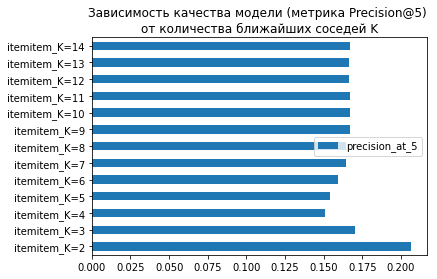

In [ ]:
precision_ItIt_K_at_5[1:].plot(kind='barh')
plt.title('Зависимость качества модели (метрика Precision@5) \nот количества ближайших соседей K') 
plt.show()


### Задание 4. Улучшение детерминированных алгоритмов
На семинаре мы рассматривали 



Далее $U \equiv N_i(u) $

$$r_{u,i} =  \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)r_{v, i}$$
$$ S = \sum\limits_{v \in U} \operatorname{sim}(u,v)$$

Предлагается улучшить эту формулу и учесть средние предпочтения всех пользователей

$$r_{u,i} = \mu + \bar{r_u} + \frac{1}{S}\sum\limits_{v \in U}\operatorname{sim}(u,v)(r_{v, i}-\bar{r_{v}} - \mu)$$

Какие смысл имееют $ \mu $ и $ \bar{r_u}$ ?

Реализуйте алгоритм, прогнозирующий рейтинги на основе данной формулы, на numpy (векторизованно!)

В качестве схожести возьмите CosineSimilarity.

Примените к user_item_matrix. В качестве рейтингов возьмите количество или стоимость купленного товара. 
Данный алгоритм предсказывает рейтинги. Как на основании предсказанных рейтингов предсказать факт покупки?

Предложите вариант.
Посчитайте accuracy@5 и сравните с алгоритмами, разобранными на вебинаре.